# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv',index_col=[0])

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.describe()

,#CigSales
count,1.440000e+02
mean,1.000280e+06
std,1.199663e+02
min,1.000104e+06
25%,1.000180e+06
50%,1.000266e+06
75%,1.000360e+06
max,1.000622e+06


Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [6]:
cigData.isnull().any()

Time         False
#CigSales    False
dtype: bool

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
# `Unnamed: 0` was assigned as the index

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData.rename(columns={'Time':'Month'}, inplace=True)

Call a head() to check this has worked. 

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [11]:
cigData.set_index('Month',inplace=True)
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [12]:
print(cigData.shape)
cigData.index.unique()

(144, 1)


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed `#CigSales` column. 

In [13]:
y = cigData['#CigSales'].resample('M').sum()

Check the type of our new variable. 

In [14]:
y.dtypes

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [15]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

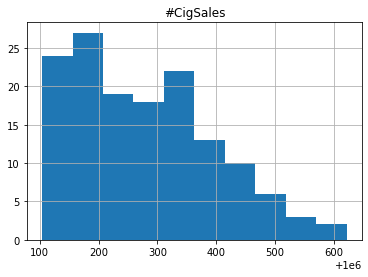

In [16]:
cigData.hist()
plt.show()

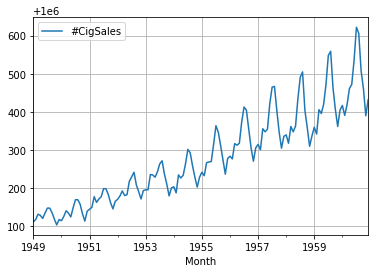

In [17]:
cigData.plot(grid=True)
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

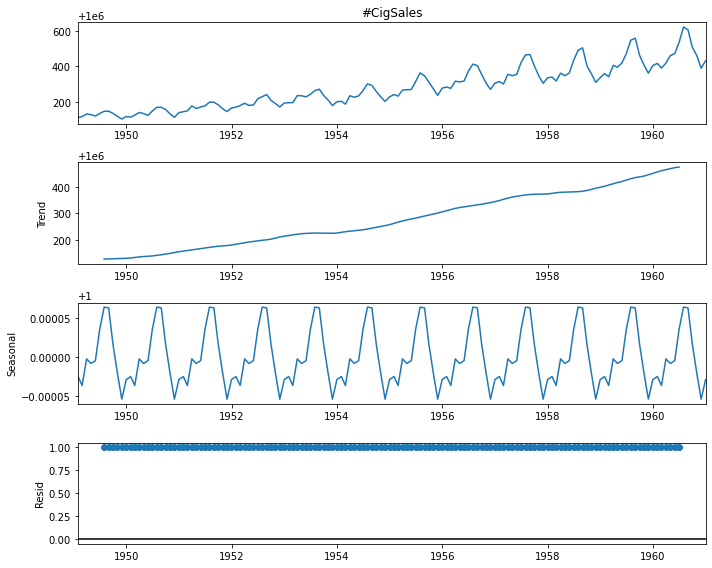

In [18]:
import statsmodels.api as sm

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

plt.rcParams['figure.figsize'] = (10, 8)
ax = decomposition.plot()

In [19]:
#decomposition.resid
#decomposition.seasonal.plot(grid=True)
#decomposition.trend
#decomposition.observed.plot(grid=True)



### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [20]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

def kpss_test(timeseries):
    '''
    Null Hypothesis: The process is trend stationary.
    Alternate Hypothesis: The series has a unit root (series is not stationary).
    
    Code adopt from
    https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    '''
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)  
    

def adf_test(timeseries):
    '''
    Null Hypothesis: The series has a unit root (non-stationary).
    Alternate Hypothesis: The series has no unit root.
    '''
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


In [21]:
kpss_test(y)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [22]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

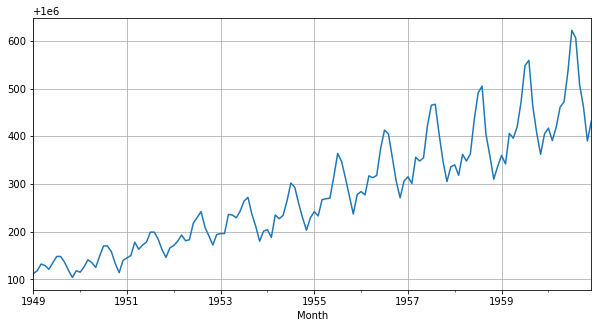

In [23]:
_ = decomposition.observed.plot(grid=True, figsize=(10, 5))

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

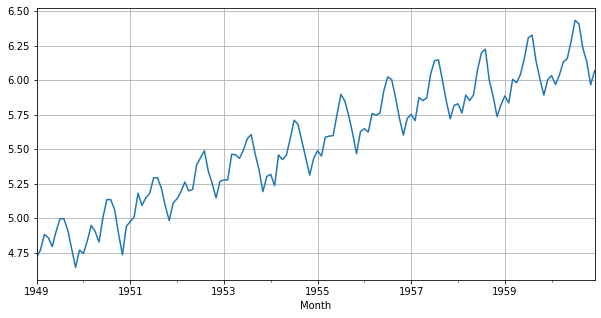

In [24]:
log_y = np.log(y-1e6)
_ = log_y.plot(grid=True, figsize=(10, 5))



When you plot this, you can see how the variance in our data now remains contant over time.

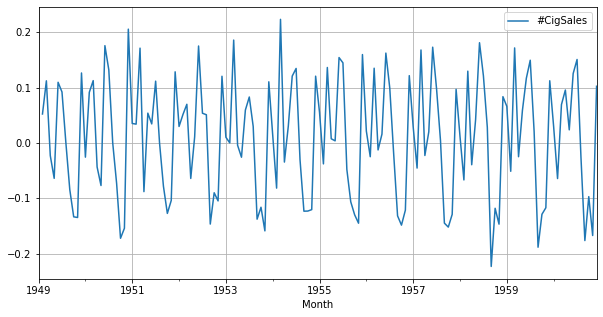

In [25]:
log_y_diff = np.log(cigData-1e6).diff()
_ = log_y_diff.plot(grid=True, figsize=(10, 5))

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [26]:
kpss_test(log_y_diff.dropna())

Results of KPSS Test:
Test Statistic           0.038304
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [27]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [28]:
def mse_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split = int(len(data) * 0.8) 
    
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]#list(train)#
    
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [29]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = mse_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [30]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [31]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(log_y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.385
ARIMA(0, 0, 1) MSE=0.108
ARIMA(0, 1, 0) MSE=0.014
ARIMA(0, 1, 1) MSE=0.012
ARIMA(0, 1, 2) MSE=0.016
ARIMA(0, 2, 0) MSE=0.019
ARIMA(0, 2, 1) MSE=0.014
ARIMA(0, 2, 2) MSE=0.013
ARIMA(1, 0, 0) MSE=0.013
ARIMA(1, 0, 1) MSE=0.012
ARIMA(1, 0, 2) MSE=0.034
ARIMA(1, 1, 0) MSE=0.013
ARIMA(1, 1, 1) MSE=0.013
ARIMA(1, 1, 2) MSE=0.011
ARIMA(1, 2, 0) MSE=0.018
ARIMA(2, 0, 0) MSE=0.012
ARIMA(2, 0, 1) MSE=0.012
ARIMA(2, 0, 2) MSE=0.014
ARIMA(2, 1, 0) MSE=0.013
ARIMA(2, 1, 1) MSE=0.010
ARIMA(2, 1, 2) MSE=0.012
ARIMA(2, 2, 0) MSE=0.019
ARIMA(2, 2, 1) MSE=0.013
ARIMA(2, 2, 2) MSE=0.013
Best ARIMA(2, 1, 1) MSE=0.010


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [32]:
p = 2
d = 1
q = 1
model = ARIMA(log_y, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [33]:
model.fit().forecast()


(array([6.19673878]), array([0.08950656]), array([[6.02130914, 6.37216842]]))

In [34]:
model.fit().predict()

Month
1949-02-28    0.010077
1949-03-31    0.018744
1949-04-30    0.025561
1949-05-31   -0.026626
1949-06-30   -0.019243
                ...   
1960-08-31   -0.021766
1960-09-30   -0.079857
1960-10-31   -0.065267
1960-11-30    0.011793
1960-12-31    0.055165
Freq: M, Length: 143, dtype: float64

In [35]:
model.fit().predict(len(log_y), len(log_y)+24)

1961-01-31    0.128313
1961-02-28    0.089985
1961-03-31    0.040963
1961-04-30    0.007872
1961-05-31   -0.004892
1961-06-30   -0.003954
1961-07-31    0.002259
1961-08-31    0.008074
1961-09-30    0.011309
1961-10-31    0.012135
1961-11-30    0.011622
1961-12-31    0.010768
1962-01-31    0.010128
1962-02-28    0.009842
1962-03-31    0.009822
1962-04-30    0.009919
1962-05-31    0.010025
1962-06-30    0.010090
1962-07-31    0.010112
1962-08-31    0.010106
1962-09-30    0.010092
1962-10-31    0.010080
1962-11-30    0.010073
1962-12-31    0.010072
1963-01-31    0.010074
Freq: M, dtype: float64

We can take a look at a summary of the model this library has built around our data.

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.#CigSales   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Mon, 19 Jul 2021   AIC                           -270.151
Time:                        23:08:47   BIC                           -255.337
Sample:                    02-28-1949   HQIC                          -264.131
                         - 12-31-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0101      0.000     23.509      0.000       0.009       0.011
ar.L1.D.#CigSales     0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.D.#CigSales    -0.4134      0.077     -5.384      0.000      -0.564      -0.263
ma.L1.D.#CigSales    -1.0000      0.028    -35.273      0.000      -1.056      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9805j            1.5553           -0.1086
AR.2            1.2073           +0.9805j            1.5553            0.1086
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

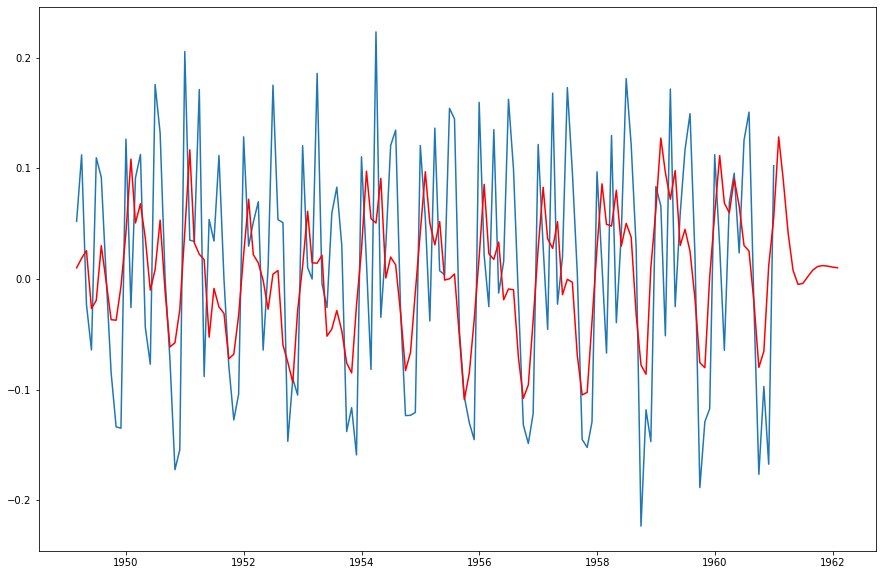

In [37]:
plt.figure(figsize=(15,10))
plt.plot(log_y.diff())
plt.plot(model_fit.predict(1, len(log_y) + 12), color = 'red')
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

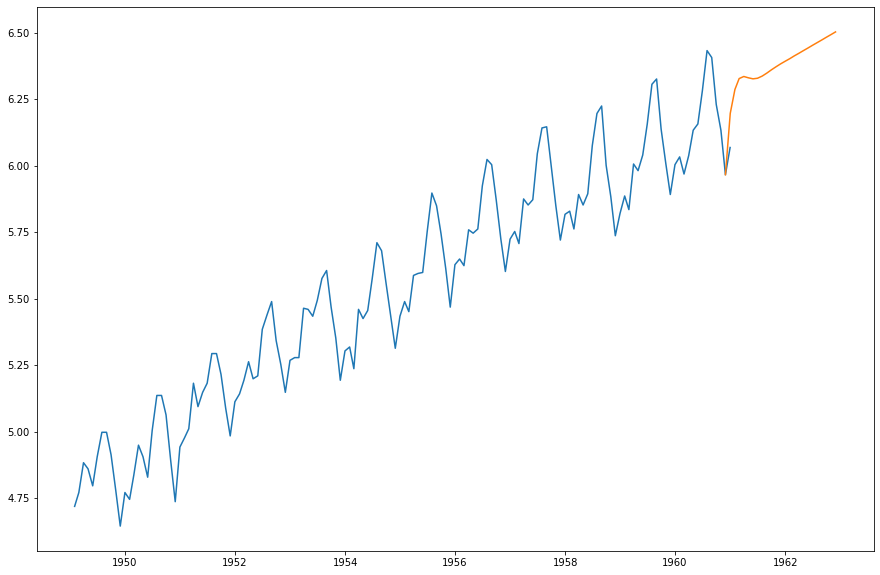

In [38]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(log_y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()


# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])


# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]


# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(log_y)
plt.plot(log_y['Nov 1960'].append(future_months['Prediction']))
plt.show()

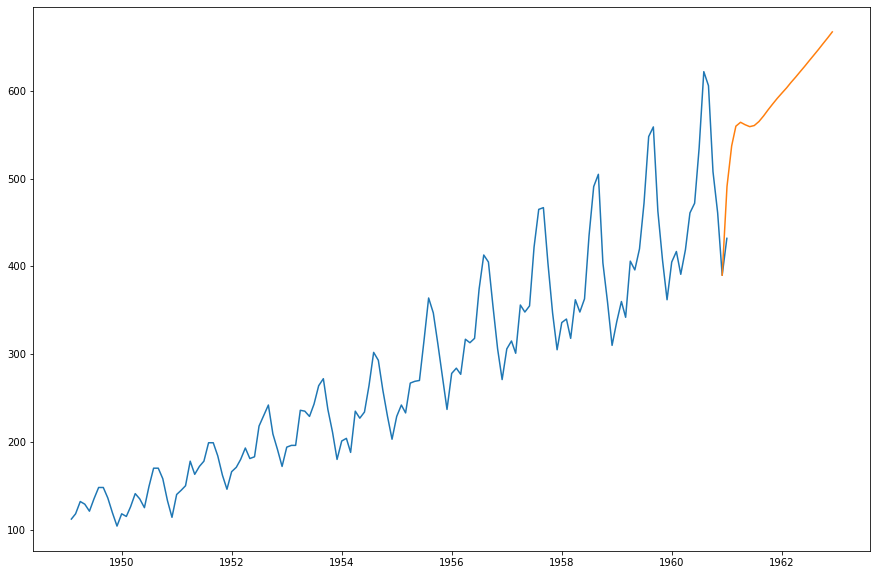

In [39]:
# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(np.exp(log_y))
plt.plot(np.exp(log_y['Nov 1960'].append(future_months['Prediction'])))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

## 5. SARIMAX model (by Mendy)

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

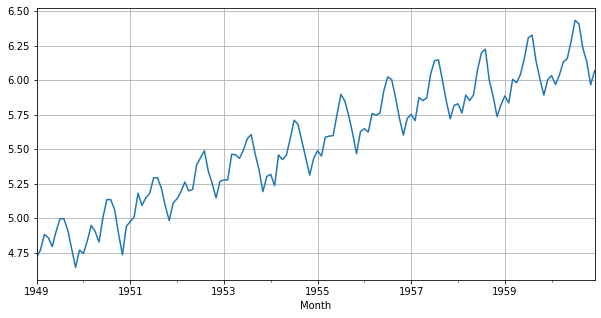

In [41]:
y = cigData['#CigSales'].resample('M').sum()
log_y = np.log(y-1e6)

_ = log_y.plot(grid=True, figsize=(10, 5))

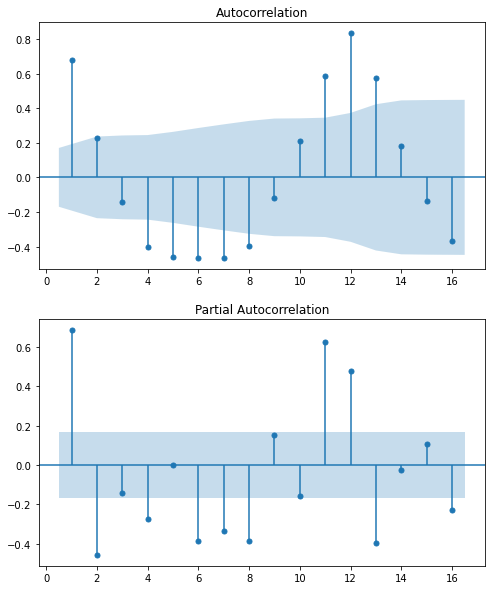

In [42]:
# Find seasonal period (S)

temp1 = (log_y-log_y.rolling(12).mean()).dropna()
input_data = temp1

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=16, zero=False, ax=ax1)
plot_pacf(input_data, lags=16, zero=False, ax=ax2)
plt.show()

# Set S=12

Results of Dickey-Fuller Test:
Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


Results of KPSS Test:
Test Statistic           0.291832
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


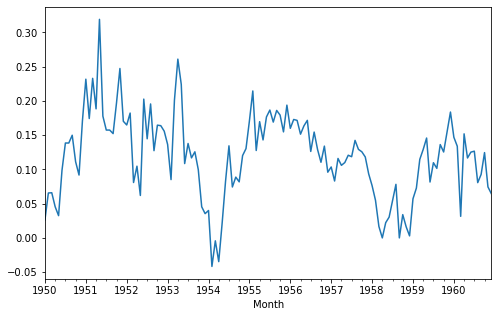

In [43]:
# Find non-seasonal (p, d, q)
input_data = log_y.diff(12).dropna() #.diff()

adf_test(input_data)
print('\n')
kpss_test(input_data)

input_data.plot(figsize=(8,5))
plt.show()

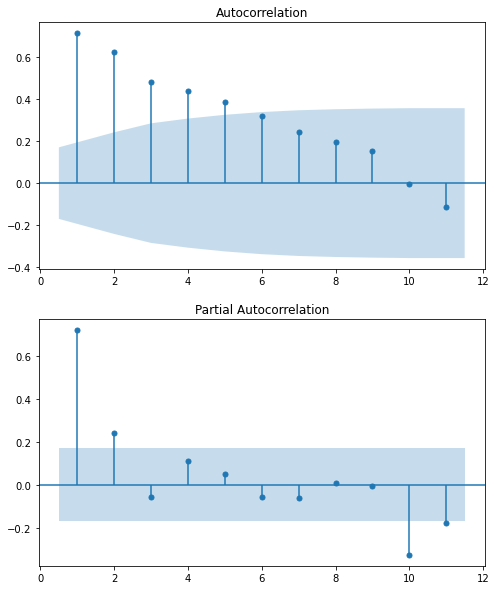

In [44]:
# Find non-seasonal (p, d, q)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
plot_acf(input_data, lags=11, zero=False, ax=ax1)
plot_pacf(input_data, lags=11, zero=False, ax=ax2)
plt.show()

# AR: p = 2, 
# d=0, q=0

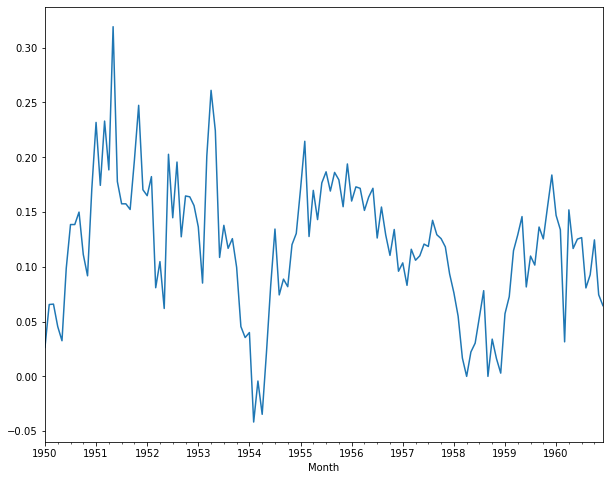

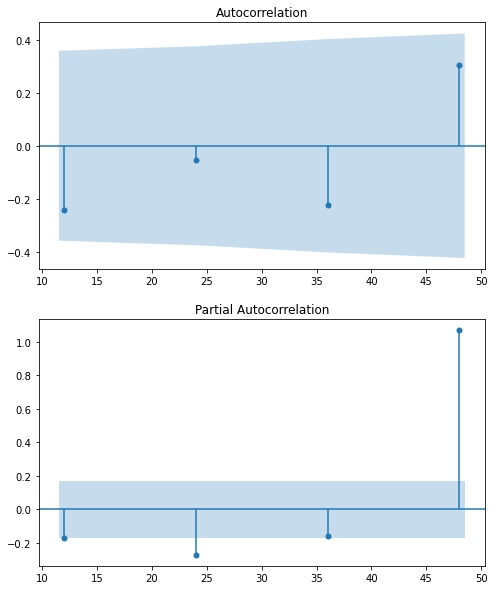

In [55]:
# Find seasonal (P, D, Q, S=12)
input_data=log_y.diff(12).dropna()
input_data.plot()
plt.show()

lags = np.arange(12, 60, 12)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.show()

# P=?, D=1, Q=?

                                      SARIMAX Results                                       
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 244.710
Date:                              Mon, 19 Jul 2021   AIC                           -481.419
Time:                                      23:08:53   BIC                           -469.888
Sample:                                  01-31-1949   HQIC                          -476.734
                                       - 12-31-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6550      0.069      9.527      0.000       0.520       0.790
ar.L2          0.33

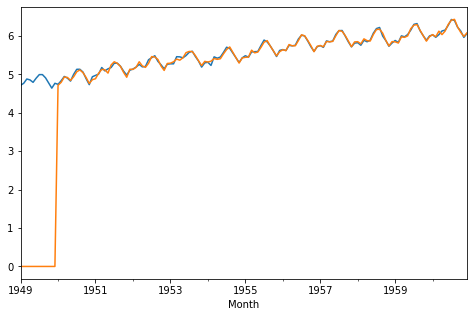

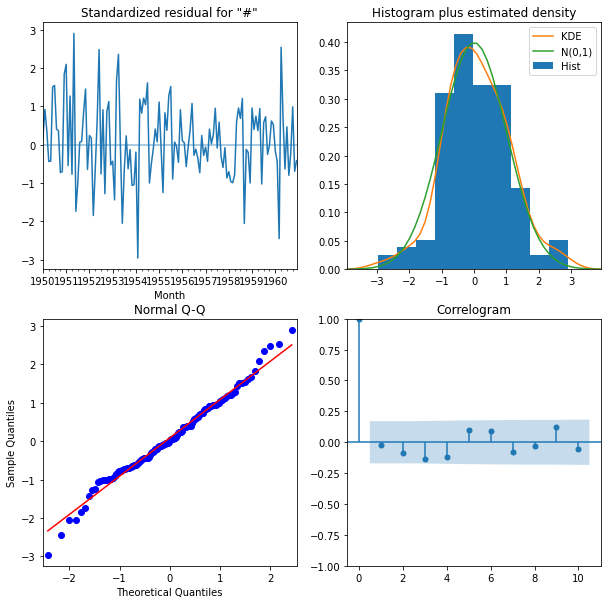

In [46]:
model = SARIMAX(log_y, order=(2,0,0), seasonal_order=(0,1,1,12))
results = model.fit()

## Summary statistics
print(results.summary())

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print('MAE:', mae)

# Make plot of time series for comparison
log_y.plot()
results.predict().plot(figsize=(8,5))
plt.show()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [47]:
import pmdarima.arima as pm

In [48]:
model1 = pm.auto_arima(
    log_y,
    seasonal=True,
    m=12,
    d=0,
    D=1,
    max_p=2,
    max_q=2,
    max_P=4,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-475.861, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=1.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-485.488, Time=2.84 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-455.363, Time=2.63 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-483.591, Time=5.18 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-479.075, Time=1.19 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-482.981, Time=4.78 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-487.030, Time=1.05 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-455.568, Time=0.86 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-477.449, Time=1.42 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-484.501, Time=3.54 sec
 ARIMA(1,0,2)(1,1,0

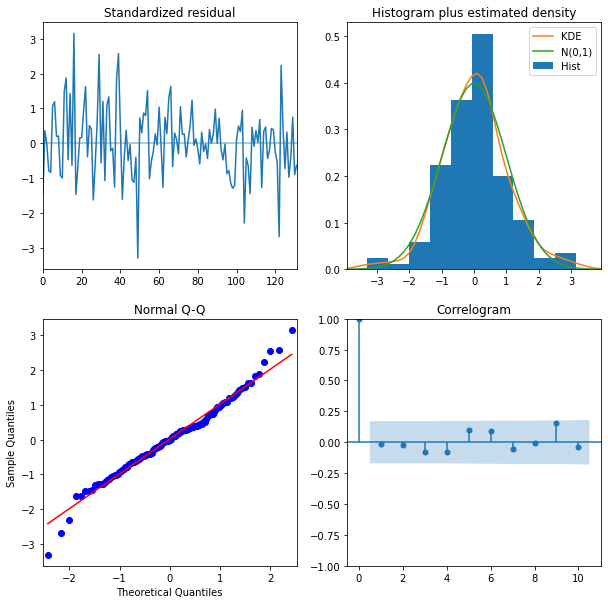

In [49]:
# Create the 4 diagostics plots
model1.plot_diagnostics(figsize=(10,10))
plt.show()

In [50]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(log_y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()
date_range = pd.to_datetime(date_range)

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])

# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)


In [51]:
# Generate predictions
results = model1
dynamic_forecast, confidence_intervals = results.predict(
    n_periods=forecast_period, dynamic=True, return_conf_int=True)

# Extract prediction mean
mean_forecast = dynamic_forecast  #.predicted_mean
future_months['Prediction'] = dynamic_forecast

# Get confidence intervals of predictions
# confidence_intervals = results.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals[:, 0]
upper_limits = confidence_intervals[:, 1]

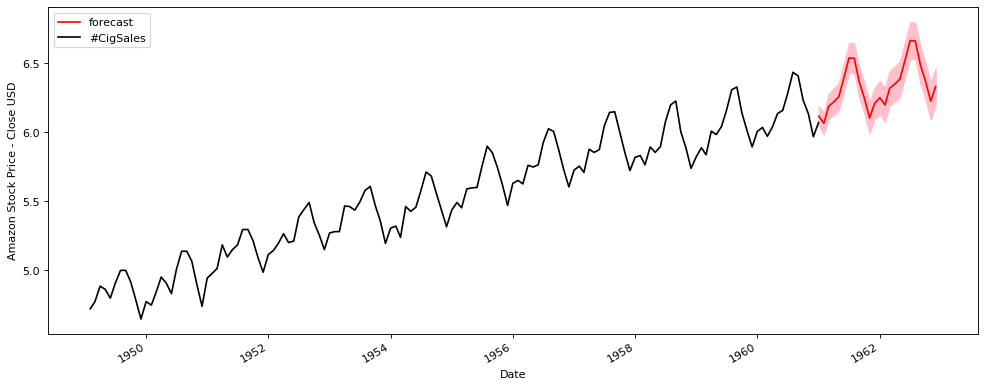

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)

# plot your mean forecast
plt.plot(date_range, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(date_range, lower_limits, upper_limits, color='pink')
log_y.plot(style='k')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()

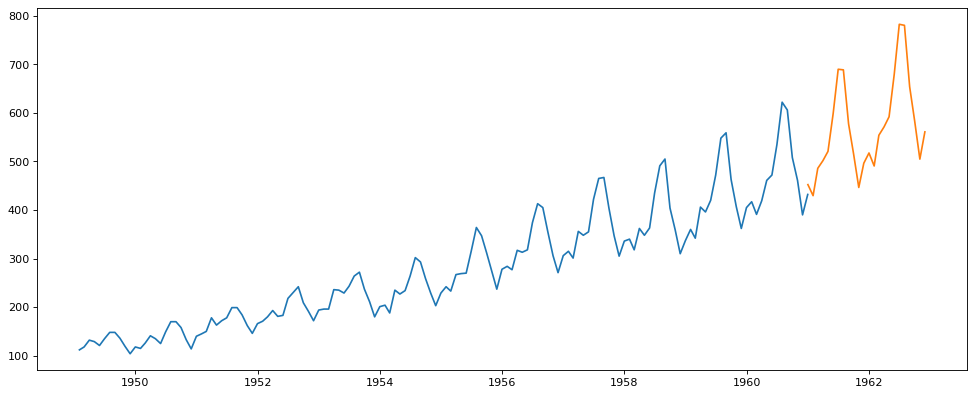

In [53]:
# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,6), dpi=80)

plt.plot(np.exp(log_y))
plt.plot(np.exp(future_months['Prediction']))
plt.show()